In [7]:
import pandas as pd
import numpy as np

# Read in Data

In [8]:
# Read Data, and save to dataframe
import os

# List of directories
directories = ['business', 'entertainment', 'food', 'graphics', 'historical', 'medical', 'other', 'politics', 'space', 'sport', 'technologie']

base_path = 'trellis_assessment_ds'

# Initialize an empty list to store the data
data = []

# Iterate over each directory
for category in directories:
    directory_path = os.path.join(base_path, category)
    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r') as file:
                text = file.read()
                data.append({'text': text, 'category': category})

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data, columns=['text', 'category'])

# Drop Other
# Identify rows where 'category' contains the word "other"
rows_to_drop = df['category'].str.contains("other")

# Save these rows to another DataFrame
df_other = df[rows_to_drop].copy()

# Drop the identified rows from the original DataFrame
df = df[~rows_to_drop]

In [9]:
df

,text,category
0,Christmas shoppers flock to tills\n\nShops all...,business
1,Record year for Chilean copper\n\nChile's copp...,business
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business
3,Battered dollar hits another low\n\nThe dollar...,business
4,US consumer confidence up\n\nConsumers' confid...,business
...,...,...
1001,"Yahoo celebrates a decade online\n\nYahoo, one...",technologie
1002,Spam e-mails tempt net shoppers\n\nComputer us...,technologie
1003,iPhone SE vs. iPhone X: Don't buy that refurbi...,technologie
1004,Looks and music to drive mobiles\n\nMobile pho...,technologie


In [10]:
# Ensure all of the data was gathered
df.category.value_counts()

category
business         100
entertainment    100
food             100
graphics         100
historical       100
medical          100
politics         100
space            100
sport            100
technologie      100
Name: count, dtype: int64

# Preprocess Data

In [54]:
"""
Code below is to preprocess the text data. All the text data will be converted to lowercase, special characters will be removed, and stop words will be removed.

Lemmatization and stemming were explored but found not useful in improving model performance.
"""

import re
import nltk
from nltk.corpus import stopwords

# Initialize stop words
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    return ' '.join(words)


df['processed_text'] = df['text'].apply(preprocess_text)

In [55]:
df['text'][0]

'Christmas shoppers flock to tills\n\nShops all over the UK reported strong sales on the last Saturday before Christmas with some claiming record-breaking numbers of festive shoppers.\n\nA spokesman for Manchester\'s Trafford Centre said it was "the biggest Christmas to date" with sales up 5%. And the Regent Street Association said shops in central London were also expecting the "best Christmas ever". That picture comes despite reports of disappointing festive sales in the last couple of weeks.\n\nThe Trafford Centre spokeswoman said about 8,500 thousand vehicles had arrived at the centre on Saturday before 1130 GMT. "We predict that the next week will continue the same trend," she added.\n\nIt was a similar story at Bluewater in Kent. Spokesman Alan Jones said he expected 150,000 shoppers to have visited by the end of Saturday and a further 100,000 on Sunday. "Our sales so far have been 2% up on the same time last year," he said. "We\'re very busy, it\'s really strong and people will 

In [56]:
df['processed_text'][0]

'christmas shoppers flock tills shops uk reported strong sales last saturday christmas claiming recordbreaking numbers festive shoppers spokesman manchesters trafford centre said biggest christmas date sales 5 regent street association said shops central london also expecting best christmas ever picture comes despite reports disappointing festive sales last couple weeks trafford centre spokeswoman said 8500 thousand vehicles arrived centre saturday 1130 gmt predict next week continue trend added similar story bluewater kent spokesman alan jones said expected 150000 shoppers visited end saturday 100000 sunday sales far 2 time last year said busy really strong people shopping right christmas christmas period expecting people spend excess 200m centre saturday afternoon spokeswoman st davids shopping centre cardiff said looked like busiest day year 200000 shoppers expected visited close play st enochs shopping centre glasgow 140000 shoppers alltime record expected passed doors closing time

In [57]:
df

,text,category,processed_text,index,label
0,Christmas shoppers flock to tills\n\nShops all...,business,christmas shoppers flock tills shops uk report...,0,0
1,Record year for Chilean copper\n\nChile's copp...,business,record year chilean copper chiles copper indus...,1,0
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business,jarvis sells tube stake spain shares engineeri...,2,0
3,Battered dollar hits another low\n\nThe dollar...,business,battered dollar hits another low dollar fallen...,3,0
4,US consumer confidence up\n\nConsumers' confid...,business,us consumer confidence consumers confidence st...,4,0
...,...,...,...,...,...
995,"Yahoo celebrates a decade online\n\nYahoo, one...",technologie,yahoo celebrates decade online yahoo one nets ...,995,9
996,Spam e-mails tempt net shoppers\n\nComputer us...,technologie,spam emails tempt net shoppers computer users ...,996,9
997,iPhone SE vs. iPhone X: Don't buy that refurbi...,technologie,iphone se vs iphone x dont buy refurbished pho...,997,9
998,Looks and music to drive mobiles\n\nMobile pho...,technologie,looks music drive mobiles mobile phones still ...,998,9


# Modeling

In [76]:
"""
The data fed into the model passed through a TF-IDF vectorizer. This vectorizer converts the text data into a matrix of TF-IDF features.
X = (1000, 32540) -> 32540 unique (words, terms, tokens) accross entire dataset. The value in each cell is the TF-IDF score for a particular term in a particular document.
y = (1000,) -> labels of the dataset

Due to the slight imbalance in the dataset, the class_weight parameter was set to 'balanced' in the Logistic Regression model. This will help the model to give more weight to the minority class.

After exploring many types of models (Logistic Regression, Naive Bayes, SVM, Random Forest, etc.), Logistic Regression was found to be the best model for this dataset. 
Logistic Reg was found to have equal performance to SVM's and even a BERT transformer model. The simplicity of the model and the speed of training made it the best choice for this dataset.

Train and test split was done with 80% of the data used for training and 20% for testing. This is a common split and adequate for the size of this dataset. 
If this dataset was larger (100k+), a 90/10 or even 95/5 split would be more appropriate.

The model was found to have an a F1-score, precision, and recall of 0.98. This seemed like an acceptable accuracy for this dataset.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])
y = df['category']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=43)

# Train model
model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

               precision    recall  f1-score   support

     business       1.00      0.85      0.92        13
entertainment       1.00      1.00      1.00        20
         food       1.00      0.96      0.98        23
     graphics       0.96      1.00      0.98        23
   historical       1.00      1.00      1.00        18
      medical       0.97      1.00      0.98        30
     politics       0.90      1.00      0.95        18
        space       1.00      1.00      1.00        16
        sport       1.00      1.00      1.00        21
  technologie       1.00      0.94      0.97        18

     accuracy                           0.98       200
    macro avg       0.98      0.97      0.98       200
 weighted avg       0.98      0.98      0.98       200



In [86]:
"""
The code below is a more complete training and evaluation of the model. The model is trained with calibrated probabilities to account for the 'other' class as required in the assement.

In this training a LabelEncoder is used to encode the labels of the dataset numerically. 

The indices of the dataset are save when dataset is split into train / test to view and analyze later

A CalibratedClassifierCV is used to pull out probabilities from the model. This is used to evaluate account for the 'other' class by setting a confidence threshold. 
A confidence threshold is set to 0.35, so that if the top probability of a prediction is lower than 0.35, the prediction is set to 'other'. 
0.35 was found to be the best threshold after testing the confidence using examples from the 'other' directory.

"""
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder

# Add an index column
df['index'] = df.index

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
num_labels = len(label_encoder.classes_)
indices = df['index']

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Split data
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X, y, indices, test_size=0.2, random_state=42)

# Train SVM model with calibrated probabilities
log_reg_model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
log_reg_model.fit(X_train, y_train)
calibrated_log_reg = CalibratedClassifierCV(log_reg_model, cv='prefit')
calibrated_log_reg.fit(X_train, y_train)

# Evaluate model
y_proba = calibrated_log_reg.predict_proba(X_val)
y_pred_log_reg = np.argmax(y_proba, axis=1)

# Set a confidence threshold
confidence_threshold = 0.35
y_pred_with_other = []
for i, proba in enumerate(y_proba):
    max_proba = np.max(proba)
    if max_proba < confidence_threshold:
        y_pred_with_other.append(num_labels)  # Assign 'other' class
    else:
        y_pred_with_other.append(y_pred_log_reg[i])

# Add 'other' to label encoder
class_names = list(label_encoder.classes_) + ['other']
print("Log Reg Model with 'other' class:")
print(classification_report(y_val, y_pred_with_other, target_names=class_names, zero_division = 0.0))


Log Reg Model with 'other' class:
               precision    recall  f1-score   support

     business       1.00      1.00      1.00        20
entertainment       1.00      1.00      1.00        13
         food       1.00      1.00      1.00        27
     graphics       0.91      0.95      0.93        21
   historical       1.00      1.00      1.00        15
      medical       0.96      1.00      0.98        22
     politics       1.00      1.00      1.00        25
        space       1.00      0.85      0.92        13
        sport       1.00      1.00      1.00        23
  technologie       1.00      0.90      0.95        21
        other       0.00      0.00      0.00         0

     accuracy                           0.97       200
    macro avg       0.90      0.88      0.89       200
 weighted avg       0.99      0.97      0.98       200



In [87]:
"""
The code below prints the examples of the misclassified data. This is useful to see what the model is getting wrong and if there is a pattern in the misclassified data.
"""

misclassified_indices = np.where(y_val != y_pred_with_other)[0]
misclassified_texts = [df.iloc[idx]['text'] for idx in misclassified_indices]

class_names = list(label_encoder.classes_) + ['other']

for pos in misclassified_indices:
    # Get the original index from the validation set indices
    index = indices_val.iloc[pos]

    print('index: ', index)
    print('description: ', df.iloc[index]['processed_text'])
    print('true class: ', df.iloc[index]['category'])
    print('pred class: ', class_names[y_pred_with_other[pos]])
    print('\n')


index:  328
description:  hello looking add voice input capability user interface developing hp730 unix workstation would greatly appreciate information anyone would care offer voice input systems easily accessible unix environment names adresses applicable vendors well experiences specific systems would helpful please respond via email post summary sufficient interest thanks ken ps found several impressive systems ibm pcs would like avoid hassle purchasing maintaining separate pc possible ken hinckley kph2qvirginiaedu university virginia neurosurgical visualization laboratory
true class:  graphics
pred class:  medical


index:  764
description:  anyone know size cold gas roll control thruster tanks sounding rockets thanks advance jim
true class:  space
pred class:  graphics


index:  917
description:  2021 acura tlx vs audi a4 bmw 330i mercedes c300 volvo s60 awd sedans stack battle premium allwheel drive sedans heats debut acuras updated tlx acura tlx certainly fans years predecessor

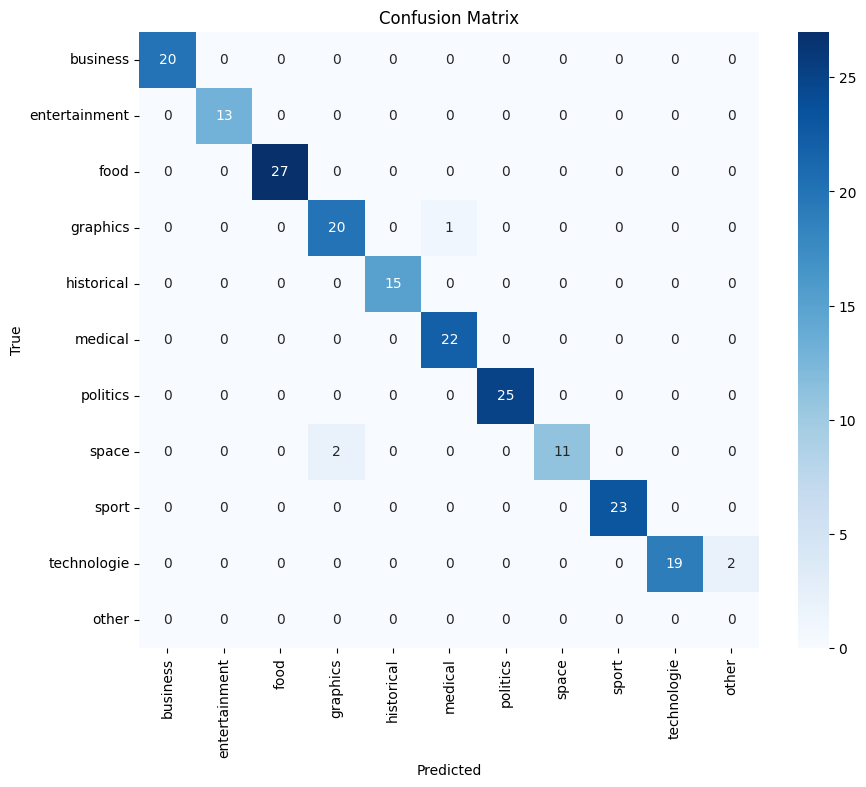

In [88]:
"""
Confusion matrix below is a visual representations of missclassified data. This is useful to see if there is a pattern in the misclassified data.
"""
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_with_other)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:
"""
Code below is identical to the training code a few cells above, except it uses Stratified K-Fold Cross Validation to evaluate the model's robustness across the dataset.

We can see that the metrics used above only drop 1% after using 5 fold cross validation. This is a good sign that the model is robust and not overfitting the data. 
"""
from sklearn.model_selection import StratifiedKFold

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
num_labels = len(label_encoder.classes_)

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Set up Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5)

# Variables to store results
all_y_true = []
all_y_pred = []

# Add 'other' to label encoder
class_names = list(label_encoder.classes_) + ['other']

for train_index, test_index in kf.split(X, y):
    # Split the data
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    # Train SVM model with calibrated probabilities
    log_reg_model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
    log_reg_model.fit(X_train, y_train)
    calibrated_log_reg = CalibratedClassifierCV(log_reg_model, cv='prefit')
    calibrated_log_reg.fit(X_train, y_train)
    
    # Evaluate model
    y_proba = calibrated_log_reg.predict_proba(X_val)
    y_pred_log_reg = np.argmax(y_proba, axis=1)
    
    # Set a confidence threshold
    confidence_threshold = 0.35
    y_pred_with_other = []
    for i, proba in enumerate(y_proba):
        max_proba = np.max(proba)
        if max_proba < confidence_threshold:
            y_pred_with_other.append(num_labels)  # Assign 'other' class
        else:
            y_pred_with_other.append(y_pred_log_reg[i])
    
    # Store results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred_with_other)

# Print classification report
print("Log Reg Model with 'other' class:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names, zero_division=0))

Log Reg Model with 'other' class:
               precision    recall  f1-score   support

     business       1.00      0.91      0.95       100
entertainment       0.99      1.00      1.00       100
         food       0.99      0.98      0.98       100
     graphics       0.96      0.96      0.96       100
   historical       0.99      0.99      0.99       100
      medical       0.95      0.96      0.96       100
     politics       0.94      0.99      0.97       100
        space       0.97      0.91      0.94       100
        sport       1.00      1.00      1.00       100
  technologie       0.99      0.95      0.97       100
        other       0.00      0.00      0.00         0

     accuracy                           0.96      1000
    macro avg       0.89      0.88      0.88      1000
 weighted avg       0.98      0.96      0.97      1000



# Other Testing

In [89]:
df_other

,text,category
600,This is a text with nothing to do with a commo...,other
601,This is a text that have nothing to do with th...,other
602,The Elmwood District Library has introduced a ...,other
603,"\nIn the sleepy town of Maple Hollow, an intri...",other
604,"In an inspiring display of community spirit, r...",other
605,\nOnce upon a late spring afternoon in the qui...,other


In [90]:
"""
The code below runs the trained model on the 'other' directory. 4/5 are correctly predicted as well as the max confidence threhold.
Looking closer at the misclassified example, it is describing a race which is understandable that the model would classify it as 'sport' instead of 'other'.
"""
# Use same vecotrizer and model to predict on the 'other' examples
other_X = vectorizer.transform(df_other['text'])
y_other_proba = calibrated_svm.predict_proba(other_X)

# For each prediction, pull out the max probability and check if above the threshold
y_pred_other = np.argmax(y_other_proba, axis=1)
for j, proba in enumerate(y_other_proba):
  max_proba = np.max(proba)
  if max_proba > 0.35:
    print(df_other.iloc[j]['text'])
    print('\nconfidence: ', max_proba)
    print('pred class: ', y_pred_other[j])
    print('guessed class: ', label_encoder.classes_[y_pred_other[j]])
    print('\n')
  else:
    print('max_proba -> ', max_proba)

max_proba ->  0.24432004693611176
max_proba ->  0.31161746138672286
max_proba ->  0.32361032205500073

In the sleepy town of Maple Hollow, an intriguing tradition captured the hearts of its residents every autumn. It was the time of the annual Leaf Race, a quirky but beloved event where the townspeople gathered along the banks of the gently flowing Willow Creek to witness a spectacle dictated not by speed, but by the whims of the wind and water.

The event was simple yet captivating: participants would choose a fallen leaf from the multitude of red, gold, and orange that blanketed the town, each hoping their selection had the magic touch. At noon, a bell would ring from the old clock tower, echoing through the crisp autumn air, signaling the start of the race.

Young and old lined the creek, holding their breath as the leaves were gently placed on the water at the starting line, marked by a string of twine stretched across the creek. The current was slow, and the wind was a fickle ally